# Qubit Two Tone Frequency Sweep

Run a sweep over the local oscillator frequency and power while reading the change in the response of the resonator. The readout needs to be set at the frequency at which the resonance is observed (for the given flux value used), ideally at the qubit sweet spot.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from IPython.display import clear_output
from time import sleep


In [96]:
lo = SGS100A_driver('TCPIP0::192.168.0.32::inst0::INSTR')
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
meas_ = 'S21'
twpa_on = False
if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.38::inst0::INSTR')
else:
    twpa = SGS100A_driver('dummy')
    
vna.open()
lo.open()
f_c = 0

Could not connect to dummy


## Two tone frequency sweep
Run a sweep over the local oscillator while reading the change in the response of the resonator. The readout needs to be set at the frequency at which the resonance is observed (for the given flux value used), ideally at the qubit sweet spot.

We find this frequency by measuring a broad spectrum and extracting from it the highest uality peak, normally associated to the principal resonance of the CPW resonator.

Center frequency: 7326844990.00 Hz
Quality Factor: 2285.235


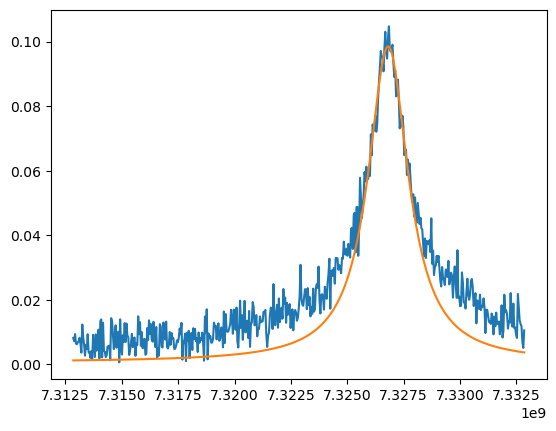

In [106]:
from datetime import datetime
params={}

params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'twotone_fpsweep'

# Qubit Parameters
# Qubit Parameters
params['qubit_name'] = 'FSCO03'
params['qubit_power'] = -10
params['twpa_power'] = 0.0
params['twpa_frequency'] = 0.0
params['twpa_on'] = False
params['vna_power'] = -60 #Single Photon Regime
params['center_freq'] = 7.322844990e9 
params['span_freq'] = 20
params['flux_curr'] = 0
params['temp'] = 22.2
params['comment'] = "# FSC03\n" +\
                    "# Qubit 01 " +\
                    "# " +\
                    "# " +\
                    "# \n"

params['qubitFreqInitial'] = 4750
params['qubitFreqFinal'] = 5150
params['qubitFreqStep'] = 5


if params['twpa_on']:
    twpa.setup(params['twpa_frequency'], params['twpa_power'])

f_c = 0
if f_c == 0:
    with twpa:
        freqs, mag, phase = meas_spectrum(vna, params['center_freq']   ,f_span=params['span_freq'], power=params['vna_power'], npoints=501,sleep_t = 10, meas = meas_)
        f_c, Qf, _ = Q(freqs,mag, True)

print('Center frequency: %2.2f Hz'%f_c)
print('Quality Factor: %2.3f'%Qf)

At this frequency we seep the drive carrier (Local Oscillator) to excite qubit and doing so affect the response seen at the resonator.

## Set test parameters

In [107]:
qubitFreq_array = np.arange(params['qubitFreqInitial'],params['qubitFreqFinal'],params['qubitFreqStep'])

# Check that the f of the resonator is correct 
if f_c == 0:
    with twpa:
        freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=201,sleep_t = 5, data_format='MA',  meas = meas_)
    f_c, Qf, fwhm = Q(freqs,mag.max()-mag, True)

#Initialize the VNA for the 2tone measurement
with twpa:
    freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 3, 
                       sleep_t = 3,  meas = meas_)

#Initialize the Local Oscillator
lo.open()
lo.set_level(params['qubit_power']) # dBm
lo.close()

maxv = np.mean(mag)

#Initialize variables for storage
mags = np.ndarray(len(qubitFreq_array))
phases = np.ndarray(len(qubitFreq_array))

mags[:] = maxv
phases[:] = 0

# Run Sweep
delay = 1.5
tt = len(qubitFreq_array)*(delay+0.5)
print('Estimated time: %2.2f min'%(tt/60))
print(maxv)


Estimated time: 2.67 min
0.10094393044716667


Stopped
file saved as twotone_fpsweep_FSCO03_20240510_1447
Qubit frequency: 4845.00 MHz, Q: 86.36


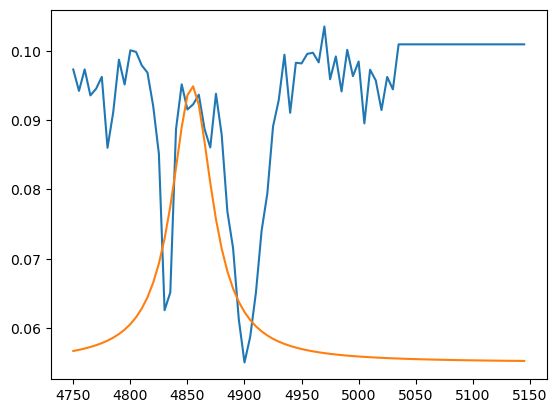

In [108]:
try:
    for idx,qfreq in enumerate(qubitFreq_array):
        clear_output(wait=True)
        with lo:
            lo.set_RF(qfreq)
            with twpa:
                sleep(0.2)
                vna.reset_average()
                sleep(delay) # VNA Readout integration time
                mag, phase =  vna.get_data( meas = meas_)

        a = np.mean(mag) #mag[1]
        if a < 1:
            mags[idx] = a
        else:
            mags[idx] = maxv

        phases[idx] = np.mean(phase) #phase[1]
        plt.plot(qubitFreq_array,20*np.log10(mags),'x')
        plt.show()
except KeyboardInterrupt:
    print("Stopped")

finally:
    results = {}
    results['mags']= mags   
    results['phases']= phases 

    header_str = get_plot_str(params)
    filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
    np.savez("./data/"+filename,
            header = header_str,
            freqs=qubitFreq_array,
            mags=mags,
            phases=phases)
    print('file saved as %s'%filename)

# Extract the qubit frequency
try:
    qubit_f, Qf,_ = Q(qubitFreq_array, mags, True)
except:
    qubit_f = qubitFreq_array[mags.argmin()]
    Qf = 0

print('Qubit frequency: %2.2f MHz, Q: %2.2f'%(qubit_f, Qf))

Qubit frequency: 5990.00 MHz, Q: 457.19


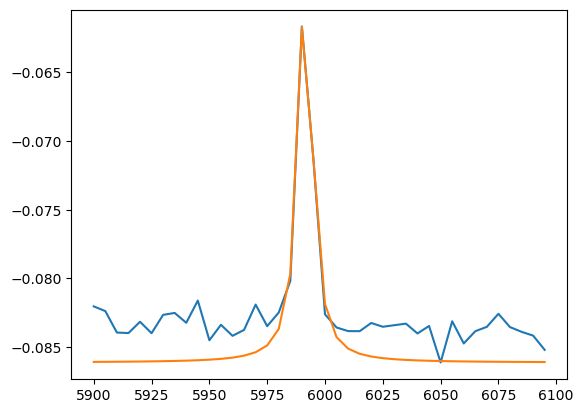

In [77]:
qubit_f, Qf,_ = Q(qubitFreq_array, 0.006-mags , True)
print('Qubit frequency: %2.2f MHz, Q: %2.2f'%(qubit_f, Qf))

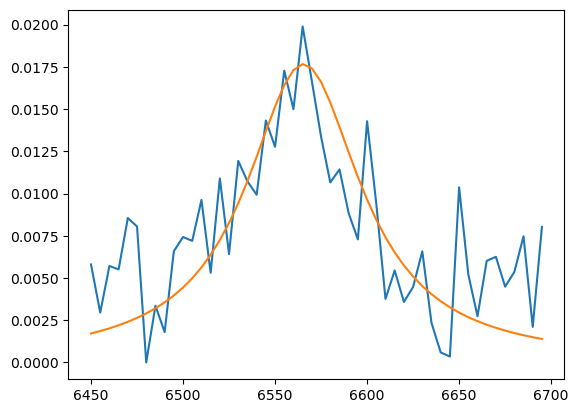  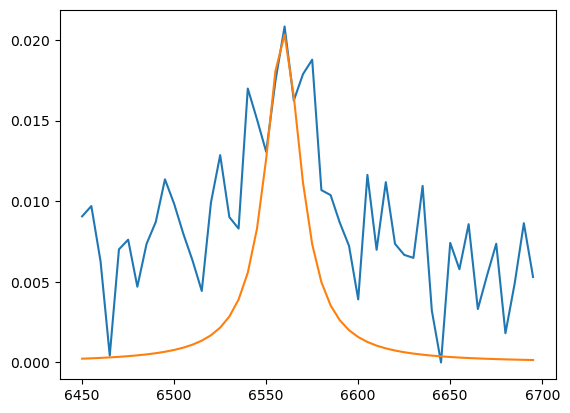